# LDA TOPIC MODELING 

Спасибо индусам за это чудо. Феноменально пофикшено by SD.




__Required Libraries__

In [2]:
import pandas as pd
import numpy as np
import os
import rnmmorphy


import string
import re
from pprint import pprint

# NLTK 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = stopwords.words('russian') #this depends on each language

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, word2vec

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

ModuleNotFoundError: No module named 'rnmmorphy'

__Loading data__

In [ ]:
df = pd.read_json('C:/Users/Sergey/Desktop/FTD_work/FTD_work/a1.json')

In [ ]:
df.shape[0]

2457

In [ ]:
df.head(20)

,text
0,"Изречение, что за правым плечом человека стоит..."
1,"Сегодня соцсети являются отдельной жизнью, в к..."
2,С изобретением селфи весь мир просто сошёл с у...
3,"Удивительно, как в современном мире люди бываю..."
4,Не буду тянуть и отвечу сразу. Нет. Российских...
5,Пользователь Инстаграм под ником Averagerob уж...
6,"Дэмиен Херст в последнее время что-то затих, и..."
7,"Вы уж извините, но пока у меня не пройдёт (а у..."
8,<o>© Фото: Елена Иванова Депутаты Госдумы иниц...
9,"У каждой национальной кухни, будь то: корейска..."


In [ ]:
data = df.text.values.tolist()

In [ ]:
pprint(data[:1])

['Изречение, что за правым плечом человека стоит ангел, а за левым - дьявол, '
 'слышали все. По поводу ангела спорить не буду, а вот насчет дьявола меня '
 'одолевают сомнения. Мне кажется, что за левым плечом у человека стоит '
 'никакой не дьявол, а таракан. Или даже несколько. Тогда они живут в голове, '
 'а на левое плечо, чтобы покомандовать, выбираются по очереди. Так сказать, '
 'несут бессменную вахту. Как правило, все тараканы - энтузиасты, обладающие '
 'настолько сильным даром убеждения, что у подшефного человека шансов '
 'поступить здраво почти не остается. Одурманенный и одураченный тараканом, '
 'человек совершает всякие глупости, за которые ему потом стыдно перед '
 'коллективом товарищей и любимой девушкой. Не в силах вынести всеобщего '
 'осуждения, провинившийся дает себе клятву с этого момента (вот прямо '
 'сейчас!) стать благоразумным и мудрым и совершать лишь хорошие и социально '
 'полезные поступки. Некоторое время у него это получается, но потом он снова '
 '

__Tokenize words and Clean-up text__

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['изречение', 'что', 'за', 'правым', 'плечом', 'человека', 'стоит', 'ангел', 'за', 'левым', 'дьявол', 'слышали', 'все', 'по', 'поводу', 'ангела', 'спорить', 'не', 'буду', 'вот', 'насчет', 'дьявола', 'меня', 'одолевают', 'сомнения', 'мне', 'кажется', 'что', 'за', 'левым', 'плечом', 'человека', 'стоит', 'никакои', 'не', 'дьявол', 'таракан', 'или', 'даже', 'несколько', 'тогда', 'они', 'живут', 'голове', 'на', 'левое', 'плечо', 'чтобы', 'покомандовать', 'выбираются', 'по', 'очереди', 'так', 'сказать', 'несут', 'бессменную', 'вахту', 'как', 'правило', 'все', 'тараканы', 'энтузиасты', 'обладающие', 'настолько', 'сильным', 'даром', 'убеждения', 'что', 'подшефного', 'человека', 'шансов', 'поступить', 'здраво', 'почти', 'не', 'остается', 'одурманенныи', 'одураченныи', 'тараканом', 'человек', 'совершает', 'всякие', 'глупости', 'за', 'которые', 'ему', 'потом', 'стыдно', 'перед', 'коллективом', 'товарищеи', 'любимои', 'девушкои', 'не', 'силах', 'вынести', 'всеобщего', 'осуждения', 'провинившиися'

__Bigrams & Trigrams__

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['изречение', 'что', 'за', 'правым', 'плечом', 'человека', 'стоит', 'ангел', 'за', 'левым', 'дьявол', 'слышали', 'все', 'по_поводу', 'ангела', 'спорить', 'не', 'буду', 'вот', 'насчет', 'дьявола', 'меня', 'одолевают', 'сомнения', 'мне_кажется', 'что', 'за', 'левым', 'плечом', 'человека', 'стоит', 'никакои', 'не', 'дьявол', 'таракан', 'или', 'даже', 'несколько', 'тогда', 'они', 'живут', 'голове', 'на', 'левое', 'плечо', 'чтобы', 'покомандовать', 'выбираются', 'по', 'очереди', 'так', 'сказать', 'несут', 'бессменную', 'вахту', 'как', 'правило', 'все', 'тараканы', 'энтузиасты', 'обладающие', 'настолько', 'сильным', 'даром', 'убеждения', 'что', 'подшефного', 'человека', 'шансов', 'поступить', 'здраво', 'почти', 'не', 'остается', 'одурманенныи', 'одураченныи', 'тараканом', 'человек', 'совершает', 'всякие', 'глупости', 'за', 'которые', 'ему', 'потом', 'стыдно', 'перед', 'коллективом', 'товарищеи', 'любимои', 'девушкои', 'не', 'силах', 'вынести', 'всеобщего', 'осуждения', 'провинившиися', 'дает

__Remove Stopwords, Make Bigrams and Lemmatize__

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

__Let’s call the functions in order__

In [ ]:
#To run this code it is necessary to get the spacy model: "!python - m spacy download ru_core_news", last depends on the used language 

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'es' model, keeping only tagger component (for efficiency)
# python3 -m spacy download es
nlp = spacy.load("ru_core_news_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['изречение', 'правый', 'плечо', 'человек', 'стоить', 'ангел', 'левый', 'дьявол', 'слышать', 'повод', 'ангел', 'спорить', 'дьявол', 'одолевать', 'сомнение', 'казаться', 'левый', 'плечо', 'человек', 'стоить', 'несколько', 'жить', 'голова', 'левый', 'плечо', 'покомандовать', 'выбираться', 'очередь', 'сказать', 'нести', 'бессменный', 'вахта', 'правило', 'тараканы', 'энтузиаст', 'обладать', 'настолько', 'сильный', 'дар', 'убеждение', 'подшефный', 'человек', 'шанс', 'поступить', 'здраво', 'оставаться', 'одурманенныи', 'одураченныи', 'таракан', 'человек', 'совершать', 'глупость', 'стыдно', 'коллектив', 'сила', 'вынести', 'всеобщий', 'осуждение', 'провинившиися', 'давать', 'клятва', 'момент', 'прямо', 'сеичас', 'стать', 'благоразумный', 'мудрый', 'совершать', 'хороший', 'социально', 'полезный', 'поступок', 'некоторое_время', 'получаться', 'снова', 'поддаваться', 'очарование', 'возникать', 'очереднои', 'конфликт', 'таракан', 'человек', 'окружающий', 'мир', 'возникает_вопрос', 'почему', 'други

__Create the Dictionary and Corpus needed for Topic Modeling__

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 3), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 3), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 2), (105, 1), (106, 1), (107, 1), (108, 1), (109, 2), (110, 1)

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary

In [ ]:
id2word[0]

'ангел'

Or, you can see a human-readable form of the corpus itself.

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('ангел', 2),
  ('бессменный', 1),
  ('благоразумный', 1),
  ('боже', 1),
  ('вахта', 1),
  ('вещеи', 1),
  ('внушить', 1),
  ('возникает_вопрос', 1),
  ('возникать', 1),
  ('вообще', 1),
  ('всеобщий', 1),
  ('выбираться', 1),
  ('выгнать', 1),
  ('вынести', 1),
  ('высказываться', 1),
  ('высокоразумных', 1),
  ('гладить', 1),
  ('глубокий', 1),
  ('глупость', 1),
  ('голова', 1),
  ('гордиться', 1),
  ('гордый', 1),
  ('грозить', 1),
  ('давать', 1),
  ('дар', 1),
  ('других', 1),
  ('дурак', 2),
  ('дьявол', 2),
  ('единственный', 1),
  ('жизнь', 1),
  ('жить', 1),
  ('затылку', 1),
  ('здраво', 1),
  ('изречение', 1),
  ('иметь', 1),
  ('инсектов', 1),
  ('каверзы', 1),
  ('каждыи', 1),
  ('казаться', 1),
  ('клятва', 1),
  ('коллектив', 1),
  ('конфликт', 1),
  ('краинем_случае', 1),
  ('ласково', 1),
  ('левый', 3),
  ('мир', 1),
  ('момент', 1),
  ('мудрый', 1),
  ('муравей', 1),
  ('муравьиный', 1),
  ('называться', 1),
  ('насекомым', 1),
  ('настолько', 1),
  ('некоторое_в

__Building the Topic Model__

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=4,
                                           alpha='auto',
                                           per_word_topics=True)

__View the topics in LDA model__

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.031*"саите" + 0.023*"блог" + 0.020*"обращение" + 0.017*"невеста" + '
  '0.011*"похудение" + 0.007*"желательно" + 0.006*"аккаунт" + 0.006*"жених" + '
  '0.005*"упоминание" + 0.005*"модератор"'),
 (1,
  '0.003*"торговец" + 0.000*"пляж" + 0.000*"труп" + 0.000*"хулео" + '
  '0.000*"убитого" + 0.000*"жалко" + 0.000*"дельфин" + 0.000*"обезьяна" + '
  '0.000*"поклонение" + 0.000*"лавка"'),
 (2,
  '0.017*"шар" + 0.015*"грудь" + 0.009*"тихо" + 0.009*"последующий" + '
  '0.008*"земной" + 0.005*"сторонои" + 0.004*"маленькои" + 0.003*"дальнеишее" '
  '+ 0.000*"стеклянныи_шар" + 0.000*"стеклянный"'),
 (3,
  '0.050*"игра" + 0.027*"команда" + 0.021*"игрок" + 0.021*"тренер" + '
  '0.020*"клуб" + 0.018*"победа" + 0.017*"матч" + 0.012*"играть" + '
  '0.011*"сезон" + 0.009*"научный"'),
 (4,
  '0.032*"год" + 0.017*"страна" + 0.011*"цена" + 0.009*"власть" + '
  '0.008*"компания" + 0.008*"рублеи" + 0.008*"государство" + 0.007*"президент" '
  '+ 0.007*"рынок" + 0.006*"политический"'),
 (5,
  '0.028

__Compute Model Perplexity and Coherence Score__

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -15.727918319270938

Coherence Score:  0.42854003025264903


__Visualize the topics-keywords__

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.406734  0.041644       1        1  31.295065
10     0.383364 -0.142147       2        1  22.975002
14     0.381923 -0.105441       3        1  18.488129
4      0.276301  0.336373       4        1  11.725686
6      0.303064 -0.072959       5        1  11.419487
3     -0.084897  0.035345       6        1   1.354215
8     -0.089700 -0.040546       7        1   1.085072
15    -0.123669 -0.005495       8        1   0.527685
5     -0.118735 -0.000262       9        1   0.514852
0     -0.124283 -0.005095      10        1   0.158106
9     -0.124153 -0.005045      11        1   0.147461
2     -0.122265 -0.004452      12        1   0.084285
11    -0.121668 -0.004290      13        1   0.076095
16    -0.121696 -0.004295      14        1   0.063533
18    -0.120812 -0.004071      15        1   0.029851
12    -0.120091 -0.003897      16        1   0.014550
1     -0.119912 -0.003856      17        1   0.012617
13    -0.119903 -0.003853      18        1   0.011775
17    -0.119808 -0.003831      19        1   0.009288
19    -0.119795 -0.003828      20        1   0.007245, topic_info=              Term         Freq        Total Category  logprob  loglift
2194       ребёнок  1065.000000  1065.000000  Default  30.0000  30.0000
123        человек  5047.000000  5047.000000  Default  29.0000  29.0000
142            год  4462.000000  4462.000000  Default  28.0000  28.0000
152        женщина  1535.000000  1535.000000  Default  27.0000  27.0000
1863       мужчина  1421.000000  1421.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
25          других     0.000636   734.691052  Topic20 -11.0506  -4.4274
26           дурак     0.000636    50.030615  Topic20 -11.0506  -1.7406
27          дьявол     0.000636    14.080699  Topic20 -11.0506  -0.4728
28    единственный     0.000636   194.038500  Topic20 -11.0506  -3.0960
29           жизнь     0.000636  2311.441684  Topic20 -11.0506  -5.5736

[1193 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6997      9  0.960369     авиация
1901      1  0.998233  автомобиль
615      10  0.846173     аккаунт
454       2  0.996965       актёр
1492      4  0.999691       акция
...     ...       ...         ...
266       1  0.572988    являться
266       2  0.263184    являться
266       3  0.009023    являться
266       4  0.154150    являться
3303      9  0.994959        ёлка

[1079 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 11, 15, 5, 7, 4, 9, 16, 6, 1, 10, 3, 12, 17, 19, 13, 2, 14, 18, 20])

__Building LDA Mallet Model__

The MALLET topic model package includes an extremely fast and highly scalable implementation of Gibbs sampling, efficient methods for document-topic hyperparameter optimization, and tools for inferring topics for new documents given trained models. 

In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ['MALLET_HOME'] = 'C:/Users/Sergey/Desktop/FTD_work/FTD_work/mallet-2.0.8'
mallet_path = 'C:/Users/Sergey/Desktop/FTD_work/FTD_work/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(6,
  [('год', 0.029433792690233673),
   ('дом', 0.01969742360695027),
   ('жить', 0.016139904134212103),
   ('стать', 0.01115937687237867),
   ('жизнь', 0.010897243858597963),
   ('человек', 0.010485320551228281),
   ('знать', 0.00951168364289994),
   ('время', 0.008725284601557819),
   ('животное', 0.0077142001198322345),
   ('начать', 0.006328639904134212)]),
 (7,
  [('деньга', 0.014873208807424954),
   ('интернет', 0.011844200225233971),
   ('нужный', 0.01098986447128267),
   ('тема', 0.01044619626422275),
   ('проект', 0.009863694613801407),
   ('писать', 0.008465690652790183),
   ('саит', 0.0068735194749718455),
   ('клиент', 0.006135684051104811),
   ('телефон', 0.006096850607743389),
   ('мочь', 0.005863849947574852)]),
 (19,
  [('фильм', 0.015408621025941096),
   ('год', 0.014160327677004095),
   ('книга', 0.011585722644821533),
   ('автор', 0.009440218451336064),
   ('история', 0.008582016773941877),
   ('картина', 0.007099668422079188),
   ('мир', 0.007060659254924907),
   

__How to find the optimal number of topics for LDA?__

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

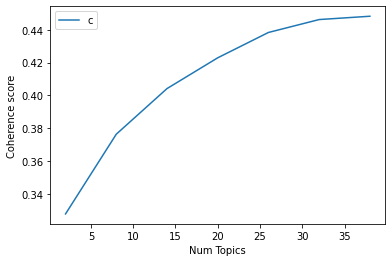

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3277
Num Topics = 8  has Coherence Value of 0.3763
Num Topics = 14  has Coherence Value of 0.4041
Num Topics = 20  has Coherence Value of 0.4229
Num Topics = 26  has Coherence Value of 0.4384
Num Topics = 32  has Coherence Value of 0.4462
Num Topics = 38  has Coherence Value of 0.4482


In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.017*"стать" + 0.016*"игра" + 0.012*"играть" + 0.010*"команда" + '
  '0.009*"группа" + 0.009*"очень" + 0.007*"клуб" + 0.007*"время" + '
  '0.007*"сеичас" + 0.007*"последний"'),
 (1,
  '0.014*"являться" + 0.011*"система" + 0.010*"мир" + 0.010*"человек" + '
  '0.008*"существовать" + 0.008*"процесс" + 0.008*"развитие" + 0.007*"иметь" + '
  '0.007*"общество" + 0.005*"свобода"'),
 (2,
  '0.020*"хотеть" + 0.017*"сказать" + 0.016*"почему" + 0.016*"вообще" + '
  '0.016*"знать" + 0.015*"говорить" + 0.014*"вопрос" + 0.014*"нужный" + '
  '0.014*"делать" + 0.013*"думать"'),
 (3,
  '0.042*"женщина" + 0.034*"мужчина" + 0.019*"любить" + 0.015*"девушка" + '
  '0.012*"отношение" + 0.011*"любовь" + 0.011*"семья" + 0.010*"муж" + '
  '0.010*"жена" + 0.010*"хотеть"'),
 (4,
  '0.018*"канал" + 0.014*"проект" + 0.011*"интересный" + 0.011*"новый" + '
  '0.011*"фотография" + 0.011*"работа" + 0.011*"очень" + '
  '0.010*"подписываитесь" + 0.010*"фото" + 0.009*"комментарий"'),
 (5,
  '0.017*"мочь" + 0.010

__Finding the dominant topic in each sentence__

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.1428,"человек, мочь, животное, людеи, собака, знать,...","Изречение, что за правым плечом человека стоит..."
1,1,7.0,0.2301,"фильм, смотреть, глаз, казаться, герой, похожи...","Сегодня соцсети являются отдельной жизнью, в к..."
2,2,4.0,0.1322,"канал, проект, интересный, новый, фотография, ...",С изобретением селфи весь мир просто сошёл с у...
3,3,19.0,0.4078,"человек, жизнь, нужный, мочь, людеи, делать, п...","Удивительно, как в современном мире люди бываю..."
4,4,7.0,0.2932,"фильм, смотреть, глаз, казаться, герой, похожи...",Не буду тянуть и отвечу сразу. Нет. Российских...
5,5,10.0,0.1081,"год, книга, тема, писать, читать, история, вре...",Пользователь Инстаграм под ником Averagerob уж...
6,6,10.0,0.1663,"год, книга, тема, писать, читать, история, вре...","Дэмиен Херст в последнее время что-то затих, и..."
7,7,10.0,0.0840,"год, книга, тема, писать, читать, история, вре...","Вы уж извините, но пока у меня не пройдёт (а у..."
8,8,17.0,0.1921,"дело, закон, решение, право, информация, сотру...",<o>© Фото: Елена Иванова Депутаты Госдумы иниц...
9,9,14.0,0.3023,"продукт, поэтому, время, организм, пить, стоит...","У каждой национальной кухни, будь то: корейска..."


In [ ]:
df_dominant_topic.shape

(2457, 5)

__Find the most representative document for each topic__

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5794,"стать, игра, играть, команда, группа, очень, к...",В матче 6 тура АПЛ встретились Ман сити и Уотф...
1,1.0,0.6367,"являться, система, мир, человек, существовать,...","Нежданно-негаданно, изменились вопросы к ГОС-э..."
2,2.0,0.3807,"хотеть, сказать, почему, вообще, знать, говори...","Сегодня день, а точнее вечер пересмотров взгля..."
3,3.0,0.4195,"женщина, мужчина, любить, девушка, отношение, ...","бля, давно не получал я такого удовольствия от..."
4,4.0,0.8206,"канал, проект, интересный, новый, фотография, ...",Оригинал взят у szgr в План ремонта и благоуст...


__Topic distribution across documents__

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,11.0,"человек, мочь, животное, людеи, собака, знать,...",142.0,0.0578
1.0,7.0,"фильм, смотреть, глаз, казаться, герой, похожи...",92.0,0.0374
2.0,4.0,"канал, проект, интересный, новый, фотография, ...",194.0,0.0790
3.0,19.0,"человек, жизнь, нужный, мочь, людеи, делать, п...",163.0,0.0663
4.0,7.0,"фильм, смотреть, глаз, казаться, герой, похожи...",93.0,0.0379
